# SD201 project

- Create dataset from scraping with steam api
- Make apriori algorithm on bought games
- Make knn algorithm on hours played
- Use steam api to make recommendations to a player

# Formulate the question

Knowing the games someone bought and how many hours they played it on Steam, what are the other games they could like and thus potentially buy ?

# Finding the dataset

We'll first test the algorithms on an already existing dataset, and we will then try to create our own dataset with Steam's api.

We choose this dataset : https://www.kaggle.com/datasets/tamber/steam-video-games.  
Indeed, it gives us a huge amount of users with their bought and played games on Steam, which will enable us to predict what kind of games they like (supposing that the more someone plays a game, the more he likes it), 

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('steam-200k.csv')

In [3]:
df.head()

,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


In [4]:
df.describe()

,151603712,1.0,0
count,1.999990e+05,199999.000000,199999.0
mean,1.036556e+08,17.874468,0.0
std,7.208084e+07,138.057292,0.0
min,5.250000e+03,0.100000,0.0
25%,4.738420e+07,1.000000,0.0
50%,8.691201e+07,1.000000,0.0
75%,1.542309e+08,1.300000,0.0
max,3.099031e+08,11754.000000,0.0


The dataset cumulates 200 000 hours played, which seems enough, and we will check the number of users and games when the data will be a little bit cleaner.

# Cleaning the data

## Renaming the columns

In [5]:
df.columns = ['id','game','state','hours_played','0']
df.head()

,id,game,state,hours_played,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


In [6]:
df['id'].nunique()

12393

In [7]:
df['game'].nunique()

5155

We have 12393 users and 5155 games in the dataset, which seems to be a good start to create recommendations.

## Removing the column always equals to 0

In [8]:
df = df.drop('0',axis=1)
df.head()

,id,game,state,hours_played
0,151603712,The Elder Scrolls V Skyrim,play,273.0
1,151603712,Fallout 4,purchase,1.0
2,151603712,Fallout 4,play,87.0
3,151603712,Spore,purchase,1.0
4,151603712,Spore,play,14.9


## Look out for NaN values

In [9]:
df.isnull().values.any()

False

There are no NaN values in the dataset

## Separate games bought and games played

In [10]:
bought_games = df.loc[df['state']=='purchase']
played_games = df.loc[df['state']=='play']

For the bought_games, the hours_played has been set to 1 but it is irrelevant, so we can drop the column

In [11]:
bought_games = bought_games.drop(['hours_played','state'],axis=1)
bought_games.head()

,id,game
1,151603712,Fallout 4
3,151603712,Spore
5,151603712,Fallout New Vegas
7,151603712,Left 4 Dead 2
9,151603712,HuniePop


In [12]:
played_games = played_games.drop(['state'],axis=1)
played_games.head()

,id,game,hours_played
0,151603712,The Elder Scrolls V Skyrim,273.0
2,151603712,Fallout 4,87.0
4,151603712,Spore,14.9
6,151603712,Fallout New Vegas,12.1
8,151603712,Left 4 Dead 2,8.9


In [18]:
played_games.id.unique() == bought_games.id.unique()

/tmp/ipykernel_16088/1183262890.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  played_games.id.unique() == bought_games.id.unique()


False

## Standardizing the data

We want to standardize the hours played so that games with higher average time played will not mess with the predictions.  

However, it is important to take care about the split between training, validation and testing. Indeed, if we standardize the whole dataset, the training set will impact the other two which is something we absolutely want to avoid.  

Thus, we will firstly standardize the whole dataset for visualization purpose, but then we will only standardize the training set, and use this standardization for each test in each notebook.  

To do so, we use the means and stds of each game to standardize them.   
In particular, we will standardize the data not to be too much affected by outliers.  


In [12]:
standardization_dict = dict()
for game_name, s in played_games.groupby('game')['hours_played']:
    standardization_dict[game_name]=dict()
    series = s[s>0.0]  #take only games played
    standardization_dict[game_name]['average'] = series.mean()
    if series.std() > 0 : #for some games that are not much played, std is 0 which creates errors
        standardization_dict[game_name]['std'] = series.std()
    else:
        standardization_dict[game_name]['std'] = 1e-8

def standardize(game, hours):
    return (hours - standardization_dict[game]['average'])/standardization_dict[game]['std']

In [13]:
standardized = played_games.copy()

standardized['hours_played'] = standardized.apply(lambda x : standardize(x.game, x.hours_played),axis=1)
standardized.head()

,id,game,hours_played
0,151603712,The Elder Scrolls V Skyrim,0.970886
2,151603712,Fallout 4,0.294820
4,151603712,Spore,-0.193861
6,151603712,Fallout New Vegas,-0.540694
8,151603712,Left 4 Dead 2,-0.223730


# Number of minimum games to keep

As we want to predict games, we can't keep people that played only 1 game because they are not useful. We have to find the line between a large number of games and a too small dataset.  
As offered by the reviews, let's use boxplots !

In [23]:
nbr_games_played = played_games.groupby('id')['game'].count()
nbr_games_played.head()

id
5250       6
76767     20
86540     15
144736     1
181212     2
Name: game, dtype: int64

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

/home/vincent/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


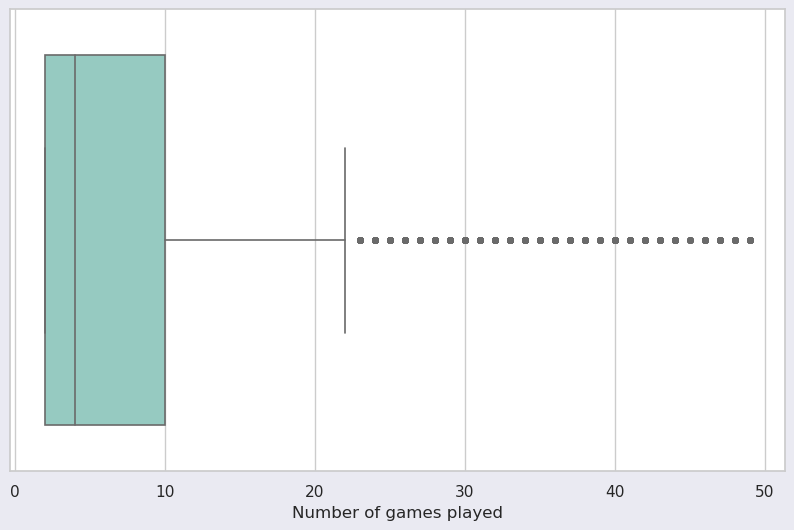

In [76]:
sns.set(style='whitegrid')
facecolor = '#eaeaf2'
fig, ax = plt.subplots(figsize=(10, 6), facecolor=facecolor)

ax = sns.boxplot(nbr_games_played.loc[(nbr_games_played<50) &  (nbr_games_played>1)], 
                 palette='Set3', 
                 linewidth=1.2, 
                 fliersize=2, 
                 flierprops=dict(marker='o', markersize=4))

ax.set_xlabel('Number of games played')

lines = ax.get_lines()
categories = ax.get_xticks()



In [69]:
nbr_games_played.loc[(nbr_games_played<50) &  (nbr_games_played>1)].quantile(0.33)

3.0

We will choose to keep players with at least 2/3 of our available data, which corresponds to 3 games minimum.

# Visualizing the data

In [14]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Density of hours played by player')

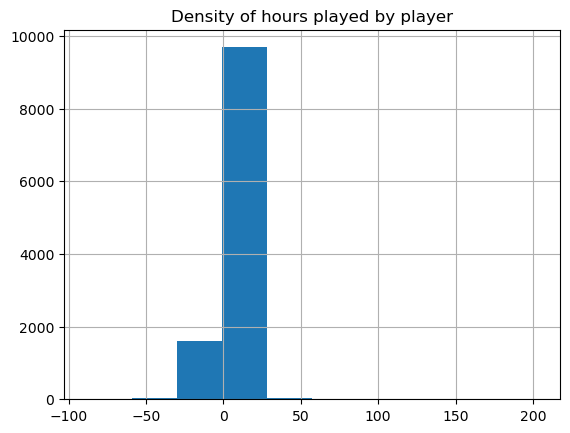

In [15]:
plt.figure()
standardized.groupby(['id'])['hours_played'].sum().hist()
plt.title('Density of hours played by player')

The vast majority of players seem to play around the average time played for a game, there are only very few outliers.

Text(0.5, 1.0, 'Density of games owned by player')

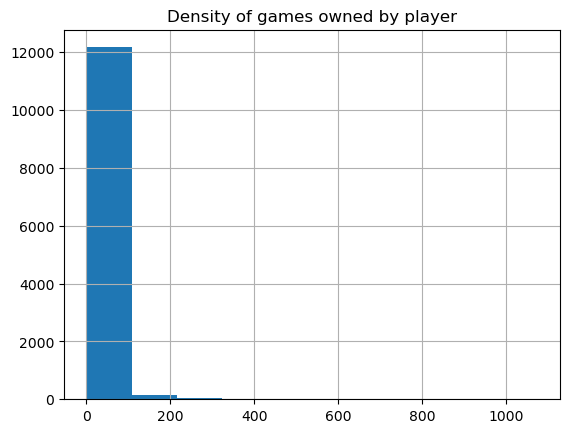

In [16]:
plt.figure()
bought_games.groupby(['id'])['game'].count().hist()
plt.title('Density of games owned by player')

In [17]:
#Mean of games bought by players
bought_games.groupby(['id'])['game'].count().mean()

10.450254175744371

It seems that the distribution is exponential, the majority of players only buy a few games, and play for a few hours. Let's check what happens for the outliers.

Text(0.5, 1.0, 'Density of hours played by outlier players')

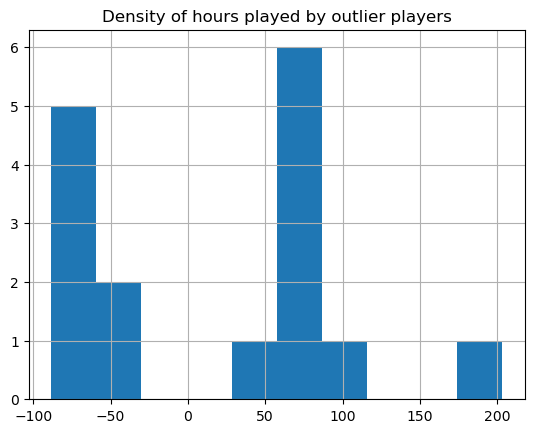

In [21]:
plt.figure()
standardized.groupby(['id'])['hours_played'].sum().loc[(standardized.groupby(['id'])['hours_played'].sum()>50) | (standardized.groupby(['id'])['hours_played'].sum()<-50)].hist()
plt.title('Density of hours played by outlier players')

Indeed, the number of outliers is really low.

Text(0.5, 1.0, 'Density of games owned by outlier players')

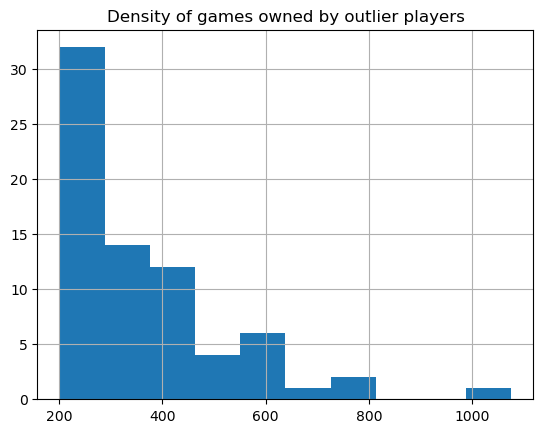

In [18]:
plt.figure()
bought_games.groupby(['id'])['game'].count().loc[bought_games.groupby(['id'])['game'].count()>200].hist()
plt.title('Density of games owned by outlier players')

Even for outliers, the exponential distribution seems to be verified.